In [1]:
%%capture
!pip install urllib3 scikit-learn numpy pandas xgboost matplotlib seaborn scipy

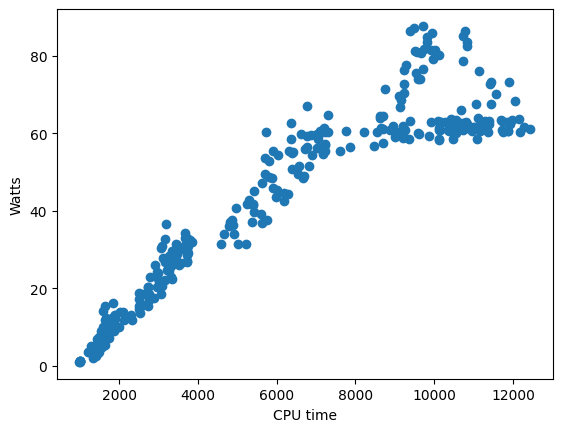

/Users/aa404681/miniconda3/envs/kepler-model-server/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [11:12:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB: r2 = 0.9292401707454121, mse = 40.663559610788525, mape = 0.15093738883437527


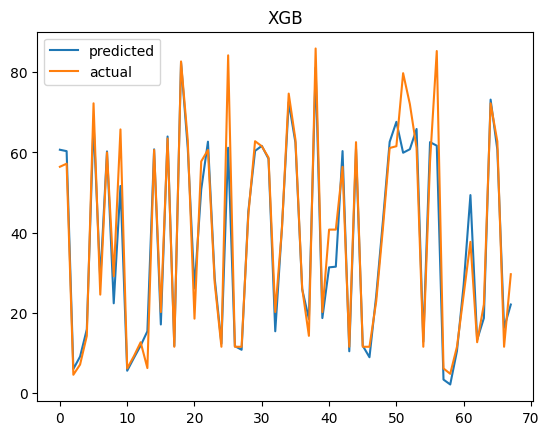

Poly: r2 = 0.9531231025955652, mse = 26.93875228437554, mape = 0.1448533853330003


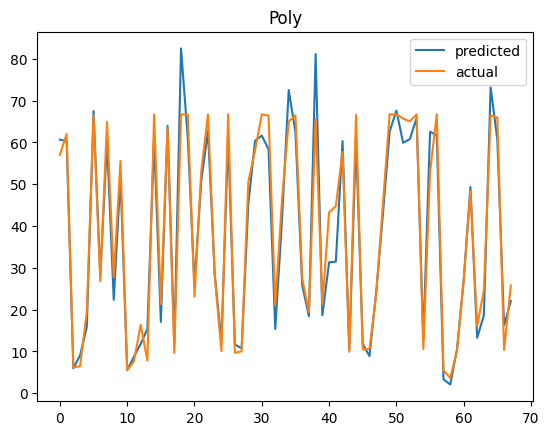

LR: r2 = 0.9051502169892285, mse = 54.50733624090517, mape = 0.34299149711478477


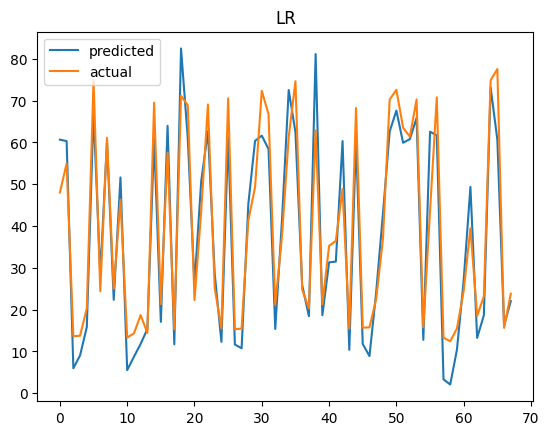

In [2]:
import urllib.request
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error


cpu_time_url = "https://raw.githubusercontent.com/sustainable-computing-io/kepler-metal-ci/refs/heads/main/docs/validation/2024-09-25/validator-v0.7.11-244-g99b1f94a/artifacts/vm-kepler_process_bpf_cpu_time_ms_total--absolute.json"
# joules_url = "https://raw.githubusercontent.com/sustainable-computing-io/kepler-metal-ci/refs/heads/main/docs/validation/2024-09-25/validator-v0.7.11-244-g99b1f94a/artifacts/vm-kepler_node_core_joules_total--absolute.json"
joules_url = "https://raw.githubusercontent.com/sustainable-computing-io/kepler-metal-ci/refs/heads/main/docs/validation/2024-09-25/validator-v0.7.11-244-g99b1f94a/artifacts/metal-kepler_vm_package_joules_total--absolute.json"

with urllib.request.urlopen(cpu_time_url) as url:
    cpu_data = json.load(url)

with urllib.request.urlopen(joules_url) as url:
    joules_data = json.load(url)

cpu_timestamps = cpu_data['timestamps']
cpu_values = cpu_data['values']

joules_timestamps = joules_data['timestamps']
joules_values = joules_data['values']

cpu_df = pd.DataFrame({
    'timestamps': cpu_timestamps,
    'cpu_values': cpu_values
})

joules_df = pd.DataFrame({
    'timestamps': joules_timestamps,
    'joules_values': joules_values
})

# plot CPU time x Watts
plt.scatter(x=cpu_values, y=joules_values)
plt.xlabel("CPU time")
plt.ylabel("Watts")
plt.show()

merged_df = pd.merge(cpu_df, joules_df, on='timestamps')

X = merged_df['cpu_values'].values.reshape(-1, 1)
y = merged_df['joules_values'].values

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

import xgboost as xgb
def print_result(model_name, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'{model_name}: r2 = {r2}, mse = {mse}, mape = {mape}')

def simple_plot(method, y_pred, y_test):
    plt.plot(y_pred, label="predicted")
    plt.plot(y_test, label="actual")
    plt.title(method)
    plt.legend()
    plt.show()

# XGBoost model
model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print_result('XGB', y_test, y_pred)
simple_plot('XGB', y_test, y_pred)

# Polynomial Regression model
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
model = LinearRegression()
model.fit(X_poly, y_train)
X_test_poly = poly.transform(X_test)
y_pred = model.predict(X_test_poly)
print_result('Poly', y_test, y_pred)
simple_plot('Poly', y_test, y_pred)

# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print_result('LR', y_test, y_pred)
simple_plot('LR', y_test, y_pred)


CurveFit: r2 = 0.9548262276339364, mse = 25.96001721319183, mape = 0.15746410869027636


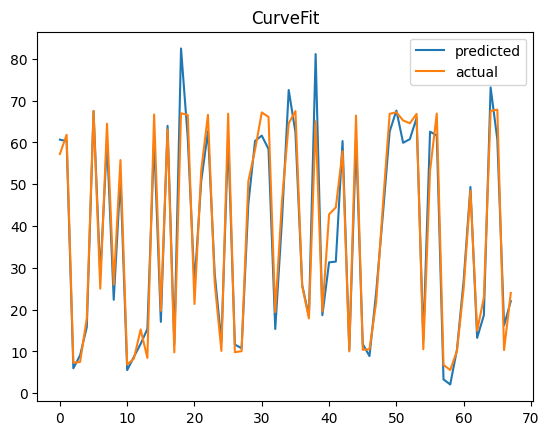

In [3]:
# Fit scaler and transform (normalize X values)
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
features = scaler.fit_transform(X_train)
flatten_x = features.flatten()
flatten_y = np.array(y_train).flatten()


# Curve fitting model
from scipy.optimize import curve_fit
def p0_func(x, y):
    A = y.max() - y.min()  # value range
    x0 = 0.5  # sigmoid mid point (as normalized value is in 0 to 1, start mid point = 0.5)
    k = A // np.std(y)  # growth rate (larger std, lower growth)
    off = y.min()  # initial offset
    return [A, x0, k, off]

def logi_func(x, A, x0, k, off):
    return A / (1 + np.exp(-k * (x - x0))) + off

test_features = scaler.transform(X_test)
popt, _ = curve_fit(logi_func, flatten_x, flatten_y, p0=p0_func(flatten_x, flatten_y), maxfev=10000)
y_pred = logi_func(test_features.flatten(), *popt)

print_result('CurveFit', y_test, y_pred)
simple_plot('CurveFit', y_test, y_pred)